In [ ]:
# !pip install xlrd==1.2.0
# !pip install openpyxl

In [1]:
import sys
sys.path.append("..")

import scripts.single_cell as single_cell
from sklearn import mixture

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.decomposition import PCA
import h5py

plt.ion()
plt.show()

def to_array(features):
    features = ' '.join(features.split()).replace(" ", ",")
    if features[1] == ',':
        features = f"[{features[2:]}"
    features = eval(features)
    return features

/usr/local/lib/python3.6/dist-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


# Microarray Analysis

In [25]:
r = pd.read_excel("../reports/scRNAseq_gmm.xlsx")

dataset_names = {
    'Quake_Smart-seq2_Trachea': "6. QS Trachea",
    'Quake_Smart-seq2_Diaphragm': "3. QS Diaphragm",
    'mouse_ES_cell': "8. Mouse ES",
    'Quake_Smart-seq2_Lung': "5. QS Lung",
    'Quake_10x_Limb_Muscle': "2. Q Limb Muscle",
    'mouse_bladder_cell': "9. Mouse Bladder",
    'Romanov': "7. Romanov",
    'Quake_Smart-seq2_Limb_Muscle': "4. QS Limb Muscle",
    'Muraro': "1. Muraro"
}

r['dataset_label'] = r['dataset_name'].apply(lambda x:dataset_names[x] )

In [18]:
rank = {}
for dataset, g in r.groupby('dataset_name'):
    g["rank_ari"] = g['ari'].rank(method='min', ascending = False)
    g["rank_silhouette"] = g['silhouette'].rank(method='min', ascending = False)
    rank[dataset] = g[g["rank_ari"] ==1]["rank_silhouette"].values[0]

In [12]:
path = "../"

data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

truth = np.array(data_mat['Y'])
data = np.array(data_mat['X'])
data = single_cell.preprocess_data(data, nb_genes = 3000, normalize_input=False)

(2746, 20670) (2746, 20670) keeping 3000 genes


Muraro
(2122, 19046) (2122, 19046) keeping 3000 genes
Quake_10x_Limb_Muscle
(3909, 23341) (3909, 23341) keeping 3000 genes
Quake_Smart-seq2_Diaphragm
(870, 23341) (870, 23341) keeping 3000 genes
Quake_Smart-seq2_Limb_Muscle
(1090, 23341) (1090, 23341) keeping 3000 genes
Quake_Smart-seq2_Lung
(1676, 23341) (1676, 23341) keeping 3000 genes
Quake_Smart-seq2_Trachea
(1350, 23341) (1350, 23341) keeping 3000 genes
Romanov
(2881, 21143) (2881, 21143) keeping 3000 genes
mouse_ES_cell
(2717, 24175) (2717, 24175) keeping 3000 genes
mouse_bladder_cell
(2746, 20670) (2746, 20670) keeping 3000 genes


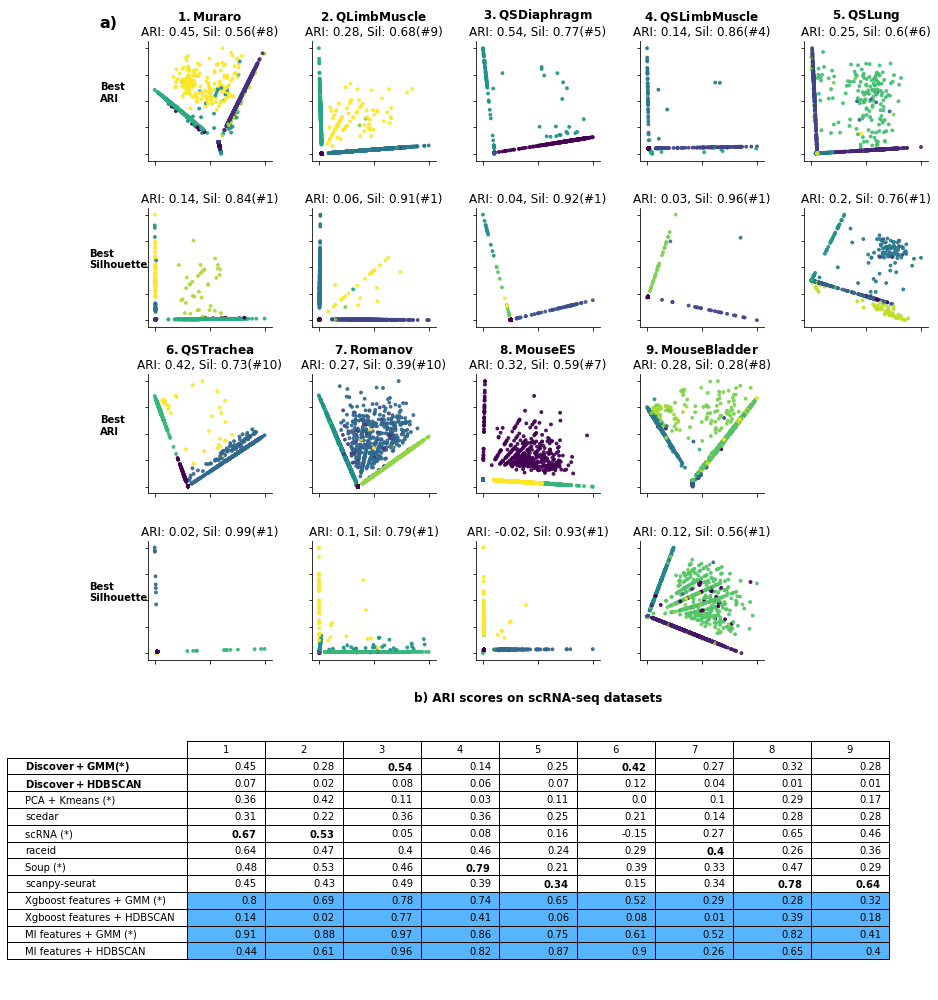

In [28]:
fig = plt.figure(figsize = (12,14))

ncol = 5
nrow = 6
gs = fig.add_gridspec(nrow, ncol)
for i, (dataset_label, g) in enumerate(r.groupby('dataset_label')):
    dataset = g["dataset_name"].unique()[0]
    print(dataset)
    row = (i) //ncol
    row *= 2
    col = i% ncol

    if i >9:
        break

    g["rank_ari"] = g['ari'].rank(method='min', ascending = False)
    g["rank_silhouette"] = g['silhouette'].rank(method='min', ascending = False)
    rank[dataset] = g[g["rank_ari"] ==1]["rank_silhouette"].values[0]
    
    data_mat = h5py.File(f"{path}/real_data/{dataset}.h5", "r")

    truth = np.array(data_mat['Y'])
    data = np.array(data_mat['X'])
    data = single_cell.preprocess_data(data, nb_genes = 3000, normalize_input=False)
    n_clusters = np.unique(truth).shape[0]

    prop = "rank_ari"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])
        
#     partition = to_array(g[g[prop] ==1]['partition'].values[0])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=0).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)

    ax = fig.add_subplot(gs[row, col])

    plt.title(r'$\bf{}$'.format(dataset_names[dataset]) +
        f"\nARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    if i in [0, 5]:
        plt.text( -0.5, 0.5, "Best\nARI", fontweight = "bold")
    if i ==0:
        plt.text( -0.5, 1.2, "a)", fontweight = "bold", fontsize = 16)


    prop = "rank_silhouette"
    features = to_array(g[g[prop] ==1]['features'].values[0])
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    partition = gmm.fit_predict(data[:, features])
#     partition = to_array(g[g[prop] ==1]['partition'].values[0])

    ari = g[g[prop] ==1]['ari'].values[0].round(2)
    silhouette = g[g[prop] ==1]['silhouette'].values[0].round(2)
    rank_silhouette = int(g[g[prop] ==1]['rank_silhouette'].values[0])

    pca_data = PCA(n_components=2, random_state=3).fit_transform(data[:, features])
    pca_data = MinMaxScaler().fit_transform(pca_data)


    ax = fig.add_subplot(gs[row+1, col])

    plt.title(f"ARI: {ari}, Sil: {silhouette}(#{rank_silhouette})")

    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=partition, alpha = 0.9, s = 8)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    if i in [0, 5]:
        plt.text(-0.6, 0.5, "Best\nSilhouette", fontweight = "bold")
sns.despine()
plt.tight_layout()


df = pd.read_excel("../results.xlsx", sheet_name = 2)
df["Dataset Index"] = df["Dataset Index"].apply(lambda x: "$\\bf{" + x+  "}$" if x.startswith("Discover") else x)

df = df.set_index("Dataset Index", drop = True)

numeric_scores = df.values[:,: -1]

values = numeric_scores.copy().astype(str)

for i in range(numeric_scores.shape[1]):
    j = np.argmax(numeric_scores[:, i][:-4])
    values[ j, i]= "$\\bf{" + str(numeric_scores[ j, i]) +  "}$"


ax = fig.add_subplot(gs[-2:, :])
ax.axis("off")
plt.title("b) ARI scores on scRNA-seq datasets", fontweight = "bold")
table = ax.table(cellText=values,
          rowLabels=df.index,
          colLabels=np.arange(numeric_scores.shape[1]).astype(int) +1,
          loc='center'
        )
table.scale(0.9, 1.4)
for r in range(len(values)-3, len(values)+1):
    for c in range(values.shape[1]):
        table[(r, c)].set_facecolor("#56b5fd")

plt.savefig(f"../images/scRNA-seq.pdf", bbox_inches='tight')

In [ ]:
df = pd.read_excel("../results.xlsx", sheet_name = 2)

In [ ]:
df

In [ ]:
df = df.set_index("Dataset Index", drop = True)

In [ ]:
numeric_scores = df.values[:,: -1]

In [ ]:
values = numeric_scores.copy().astype(str)

In [ ]:
for i in range(numeric_scores.shape[1]):
    j = np.argmax(numeric_scores[:, i][:-4])
    values[ j, i]= "$\\bf{" + str(numeric_scores[ j, i]) +  "}$"

In [ ]:
plt.figure(figsize = (12,8))
ax = plt.subplot(1, 1, 1)
ax.axis("off")
table = ax.table(cellText=values,
          rowLabels=df.index,
          colLabels=df.columns,
          loc='center left'
        )

for r in range(len(values)-3, len(values)+1):
    for c in range(values.shape[1]):
        table[(r, c)].set_facecolor("#56b5fd")
# plt.title("(a)", fontweight = "bold")
# table.scale(0.9, 1.5)
# table.set_fontsize(12)

In [ ]:
["alon", "borovecki", "chiaretti", "christensen", "golub", "gordon", "khan", "sorlie", "su", "yeoh", "west"]


In [ ]:
sns.barplot(y = "Dataset Index", x = 1, data = df)
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[1].set_fontweight('bold') 
plt.gca().get_yticklabels()[-4].set_color('red') 
plt.gca().get_yticklabels()[-3].set_color('red') 
plt.gca().get_yticklabels()[-2].set_color('red') 
plt.gca().get_yticklabels()[-1].set_color('red') 
plt.ylabel("")
plt.xlabel("ARI")
plt.grid()
sns.despine()